In [182]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as stats
cwd = os.getcwd()
plots = os.path.join(cwd,'plots')
max_anlge = 59.2 #deg

# data files for the 180 test:
data_180 = (np.loadtxt(cwd + r'\data\test_new_tia.csv', skiprows=1, delimiter=',')).T
print(data_180.shape)
time = (data_180[0] - data_180[0][0])*1e-6
alpha = data_180[9]
tan_alpha = data_180[7]
true_alpha = -data_180[1]/16*0.9
tan_true_alpha = np.tan(true_alpha/180*np.pi)

# data files for the 90 deg test:

# data files for the 45 deg test:

#data files for the 135 deg test:

(11, 20100)


In [174]:
def train_test(data, n):
    #separate test train
    data_split = np.split(data, len(tan_alpha)/100) # there are 100 measuerments per setting
    data_split = np.split(np.array(data_split), 2, axis=1)
    data_train = data_split[0]
    data_test = data_split[1]
    return data_test, data_train

def mean_diff(true, estimate):
    avg = np.average(estimate - true)
    return avg

alpha_test, alpha_train = train_test(tan_alpha, tan_alpha/100)
alpha_true_test, alpha_true_train = train_test(tan_true_alpha, tan_true_alpha/100)

In [180]:
pror_err_train = mean_diff(alpha_train, alpha_true_train)
corrected_alpha_train = alpha_train + pror_err_train
post_err_train = mean_diff(corrected_alpha_train, alpha_true_train)
# correct the test set:
corrected_alpha_test = alpha_test + pror_err_train
post_err_test = mean_diff(corrected_alpha_test, alpha_true_test)
base_err_test = mean_diff(alpha_test, alpha_true_test)

In [181]:
print("Error prior to calb (trainset):", pror_err_train)
print("Error after calb (trainset):", post_err_train)
print("Error prior to calb (testset):", base_err_test)
print("Error after calb (testset):", post_err_test)

Error prior to calb (trainset): -0.0005970149253731343
Error after calb (trainset): -1.414015394547463e-17
Error prior to calb (testset): 0.001445771144278607
Error after calb (testset): 0.002042786069651729


In [117]:
# plot the averaged angles over 100 measurements:
datas = np.split(data_180[9], len(data_180[9])/100)
trues = np.split(data_180[1], len(data_180[1])/100)
averaged_alpha = np.average(datas,axis=1)
true_averaged_alpha = -np.average(trues,axis=1)/16*0.9

In [110]:
averaged_alpha

array([ 58.9931,  58.6172,  59.0697,  59.1134,  58.986 ,  59.0607,
        58.6001,  58.4882,  58.1073,  57.8086,  57.295 ,  56.5245,
        54.9686,  53.6283,  52.9057,  52.5827,  52.5198,  52.4815,
        51.7798,  50.4954,  49.0224,  48.3343,  47.9401,  47.1409,
        46.6111,  46.4523,  46.2547,  46.4475,  45.7739,  44.6632,
        44.122 ,  42.7984,  41.7081,  40.6542,  40.0588,  39.3153,
        39.4741,  39.0579,  38.4316,  37.5555,  37.3709,  36.746 ,
        35.6891,  34.6272,  33.8079,  33.7587,  33.5698,  33.9499,
        33.7294,  34.1763,  33.8172,  32.3846,  31.5535,  31.0442,
        30.4481,  29.0852,  28.3289,  27.3655,  26.6095,  25.9725,
        24.9181,  23.5317,  22.9609,  22.5309,  22.0185,  20.9332,
        19.8348,  18.8269,  18.2089,  18.0919,  17.9526,  17.2918,
        16.571 ,  15.9868,  15.7706,  14.5754,  13.8315,  12.745 ,
        11.8332,  11.3409,   9.987 ,  10.1595,   9.6758,   9.3617,
         7.9635,   6.0158,   5.3243,   4.0328,   4.2388,   3.9

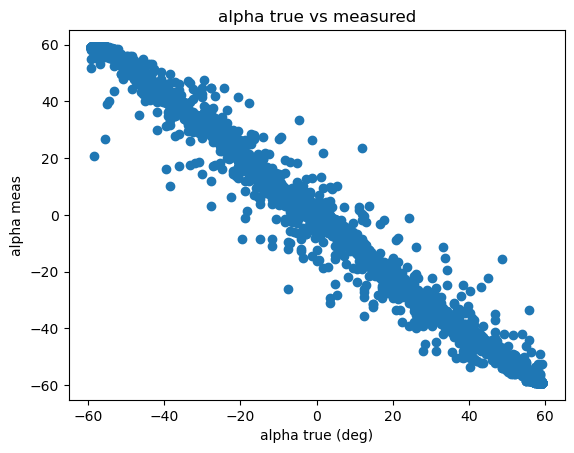

In [118]:
#Plot angle alpha against the true angle alpha. They are opposite for the 180 case
plt.scatter(data_180[1]*0.9/16, data_180[9])
plt.title("alpha true vs measured")
plt.ylabel("alpha meas")
plt.xlabel("alpha true (deg)")
plt.show()
dgs = (data_180[1] * 0.9 / 16 < 59.2) & (data_180[1] * 0.9 / 16 > -59.2)
(data_180[9][dgs] + (data_180[1]*0.9/16)[dgs]).reshape(-1,)
freq = np.fft.rfftfreq(len(time[dgs]), time[1]-time[0])

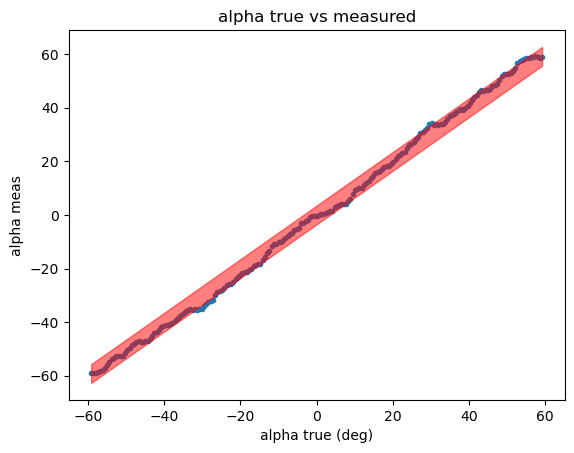

In [123]:
#plot averages
plt.scatter(true_averaged_alpha, averaged_alpha, marker = '.')
plt.fill_between(true_averaged_alpha, true_averaged_alpha+3.5, true_averaged_alpha-3.5, alpha=0.5, color="red")
plt.title("alpha true vs measured")
plt.ylabel("alpha meas")
plt.xlabel("alpha true (deg)")
plt.show()
dgs = (data_180[1] * 0.9 / 16 < 59.2) & (data_180[1] * 0.9 / 16 > -59.2)
(data_180[9][dgs] + (data_180[1]*0.9/16)[dgs]).reshape(-1,)
freq = np.fft.rfftfreq(len(time[dgs]), time[1]-time[0])

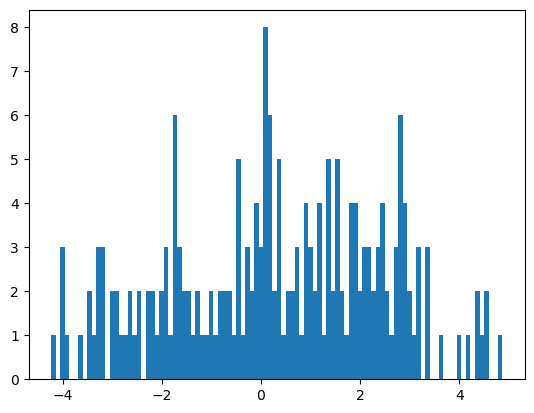

In [132]:
error = true_averaged_alpha - averaged_alpha
plt.hist(error, bins=100)
plt.show()

In [ ]:
np.len(np.where())

In [86]:
#np.where(np.tan(data_180[1]*0.9/16/180*np.pi)==np.nan)
data_180[7][dgs]

array([ 1.  ,  1.01,  0.9 , ..., -1.11, -1.14, -1.1 ])

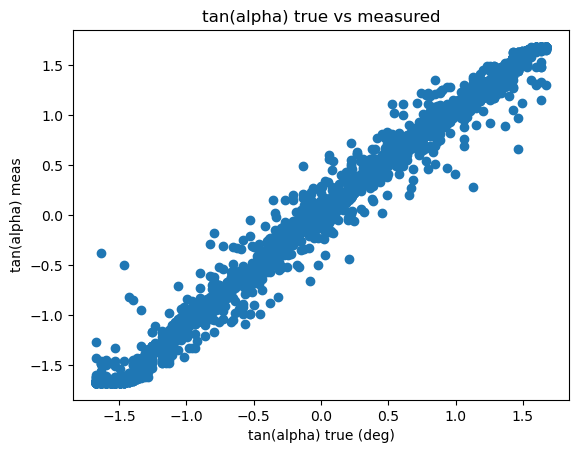

In [133]:
# now do the same with the tangent angles:
#Plot angle alpha against the true angle alpha. They are opposite for the 180 case
true_tangents = np.tan(data_180[1]*0.9/16/180*np.pi)[dgs]
plt.scatter(np.tan(data_180[1]*0.9/16/180*np.pi)[dgs], -data_180[7][dgs])
plt.title("tan(alpha) true vs measured")
plt.ylabel("tan(alpha) meas")
plt.xlabel("tan(alpha) true (deg)")
plt.show()
dgs = (data_180[1] * 0.9 / 16 < 59.2) & (data_180[1] * 0.9 / 16 > -59.2)
(data_180[9][dgs] + (data_180[1]*0.9/16)[dgs]).reshape(-1,)
freq = np.fft.rfftfreq(len(time[dgs]), time[1]-time[0])

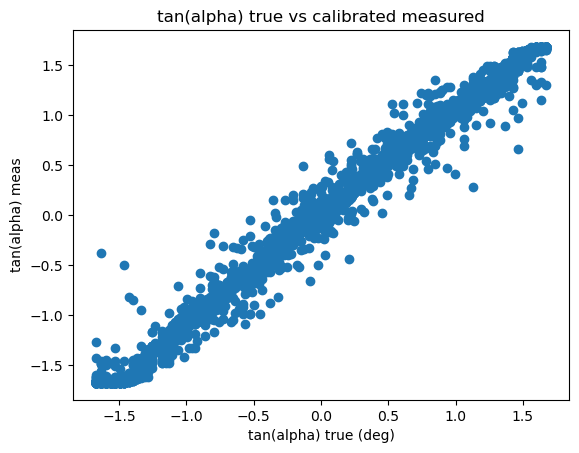

In [134]:
# calibrate with a constant by removing the average error
avg_err = np.average(np.tan(data_180[1]*0.9/16/180*np.pi)[dgs] - data_180[7][dgs])
corrected = -data_180[7][dgs] - avg_err
plt.scatter(np.tan(data_180[1]*0.9/16/180*np.pi)[dgs], corrected)
plt.title("tan(alpha) true vs calibrated measured")
plt.ylabel("tan(alpha) meas")
plt.xlabel("tan(alpha) true (deg)")
plt.show()

In [135]:
#plot error histogram
calibrated_error = corrected

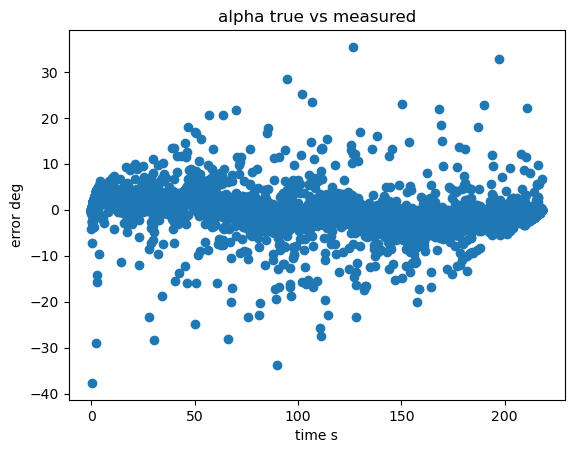

In [136]:
# do the error measurement
plt.scatter(time[dgs], (data_180[9]+data_180[1]*0.9/16)[dgs])
plt.title("alpha true vs measured")
plt.ylabel("error deg")
plt.xlabel("time s")
plt.show()
dgs = (data_180[1] * 0.9 / 16 < 59.2) & (data_180[1] * 0.9 / 16 > -59.2)
(data_180[9][dgs] + (data_180[1]*0.9/16)[dgs]).reshape(-1,)
freq = np.fft.rfftfreq(len(time[dgs]), time[1]-time[0])

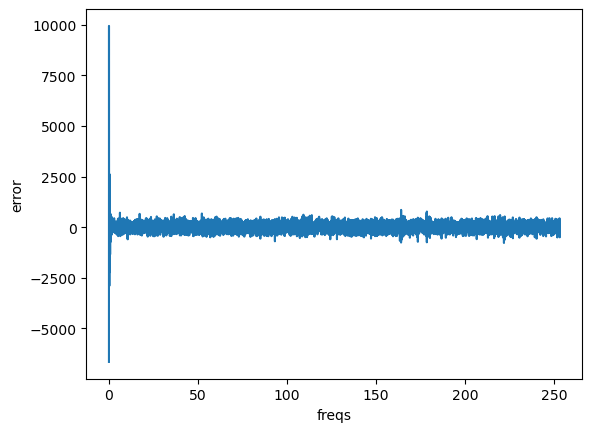

In [137]:
error = (data_180[9] + data_180[1]*0.9/16)[dgs]
error_fft = np.fft.rfft(error)
#We see a misalignment with period of 200 seconds this is a freq of 0.005
plt.plot(freq, error_fft)
plt.xlabel("freqs")
plt.ylabel("error")
plt.show()

In [159]:
# apply the quad cell calibration formula to minimize the erorr
def err(estimate,true):
    err = np.average((estimate - true)**2)
    return err

def grad(f, estimat, true, input):
    return 0

error = err(tan_alpha,tan_true_alpha)

# correct error by adding constant:
correction_scalar = error
# look at the corrected data
tan_alpha_corr = tan_alpha - correction_scalar

In [160]:
err(tan_alpha_corr,tan_true_alpha)

0.0070360620766354

In [161]:
error

0.006981396673282585

58.67564768354188